In [16]:
import matplotlib.pyplot as plt
import os
import json
import numpy as np
import pandas as pd

In [17]:
# Select the dataset you need
#dataset_name = "kvasir"
#dataset_name = "NucleiSeg"
#dataset_name = "URDE"
dataset_name = "isaid"
#dataset_name = "coco"

# Replace by source dir location
source_dir = f'/home/rob/Documents/3_projects/bench/analysis/large_models/{dataset_name}'

In [18]:
def show_CI_graph(dataset_name: str, source_dir: str, binary: bool = True) -> None:
    # Load JSON files
    json_files = [f for f in os.listdir(source_dir) if f.endswith('.json')]
    
    # Dictionary to store the data
    data = {}
    
    # Load each JSON file and store the data
    for json_file in json_files:
        with open(os.path.join(source_dir, json_file), 'r') as f:
            data[json_file] = json.load(f)
    
    # Extract the mean values and confidence intervals for each metric from each model
    if binary:
        metrics = ['dice_score', 'IoU_score', 'precision_metric', 'recall_metric', 'accuracy_metric']
    else:
        metrics = ['IoU_score', 'precision_metric', 'recall_metric', 'accuracy_metric', 'fw_iou', 'pacc']
    
    model_names = list(data.keys())
    mean_values = {metric: [] for metric in metrics}
    ci_values = {metric: [] for metric in metrics}
    legend_labels = []
    
    # Define a color map for the models
    colors = plt.cm.tab20.colors  # Tab20 colormap, which has 20 colors
    model_colors = {model: colors[i % len(colors)] for i, model in enumerate(model_names)}  # Assign a color to each model
    
    for model in model_names:
        # Clean up the model name and append the number of parameters
        cleaned_model_name = model.replace('_data.json', '')
        num_params = data[model]['num_params']
        legend_labels.append(f'{cleaned_model_name} (Params: {num_params:,})')
        
        for metric in metrics:
            mean = data[model][metric]['mean'] * 100  # Convert to percentage
            ci_lower = data[model][metric]['95% CI'][0] * 100
            ci_upper = data[model][metric]['95% CI'][1] * 100
            mean_values[metric].append(mean)
            ci_values[metric].append([ci_lower, ci_upper])
    
    # Plotting the data using box plots
    fig, ax = plt.subplots(figsize=(14, 6))
    
    positions = []
    for i, metric in enumerate(metrics):
        # Data for boxplot: mean is marked, CI as the box, min/max as the whiskers
        box_data = [ci_values[metric][j] for j in range(len(model_names))]
        pos = np.arange(len(model_names)) + i * (len(model_names) + 1)
        positions.extend(pos)
        
        # Plot boxplot for each metric with consistent colors
        bp = ax.boxplot(box_data, positions=pos, widths=0.6, patch_artist=True, 
                        showmeans=True, meanline=False, 
                        meanprops=dict(marker='o', markerfacecolor='red', markeredgecolor='black', markersize=10))
        
        # Assign consistent colors to boxes based on model_colors mapping
        for j, patch in enumerate(bp['boxes']):
            patch.set_facecolor(model_colors[model_names[j]])
    
        for j in range(len(model_names)):
            ax.text(pos[j], mean_values[metric][j], f'{mean_values[metric][j]:.2f}%', 
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Customizing the plot
    ax.set_xlabel('Metrics', fontsize=10)
    ax.set_ylabel('Values (%)', fontsize=10)
    ax.set_title(f'Performance Comparison with 95% Confidence Intervals - {dataset_name}', fontsize=14)
    ax.set_xticks(np.arange(len(metrics)) * (len(model_names) + 1) + (len(model_names) - 1) / 2)
    ax.set_xticklabels(metrics, fontsize=10)
    
    # Rotate the tick labels for better readability
    plt.xticks(rotation=45)
    
    # Create a legend with consistent colors
    legend_handles = [plt.Line2D([0], [0], color=model_colors[model], lw=4) for model in model_names]
    ax.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=len(model_names), fontsize=8, title="Models")
    
    # Show plot
    plt.tight_layout()
    
    # Save as pdf
    output_path = os.path.join(source_dir, f'{dataset_name}_performance_comparison_with_CI.pdf')
    plt.savefig(output_path, format='pdf')
    
    plt.show()


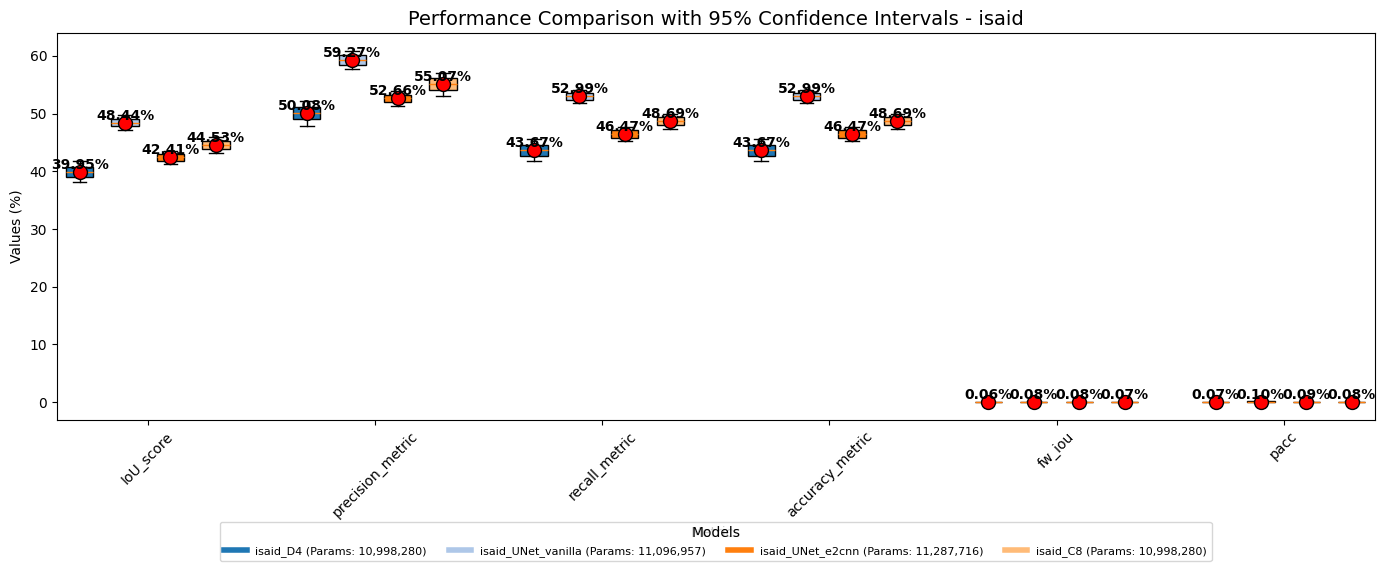

In [19]:
if dataset_name in ["kvasir", "NucleiSeg", "URDE"]:
    binary = True
else:
    binary = False
show_CI_graph(dataset_name, source_dir, binary=binary)

In [20]:
def create_performance_table(dataset_name: str, source_dir: str, binary: bool = True) -> None:
    # Load JSON files
    json_files = [f for f in os.listdir(source_dir) if f.endswith('.json')]
    
    # Dictionary to store the data
    data = {}
    
    # Load each JSON file and store the data
    for json_file in json_files:
        with open(os.path.join(source_dir, json_file), 'r') as f:
            data[json_file] = json.load(f)
    
    # Define metrics based on whether the task is binary or not
    if binary:
        metrics = ['dice_score', 'IoU_score', 'precision_metric', 'recall_metric', 'accuracy_metric']
    else:
        metrics = ['IoU_score', 'precision_metric', 'recall_metric', 'accuracy_metric', 'fw_iou', 'pacc']
    
    # Initialize a DataFrame to store the results
    results_df = pd.DataFrame(index=metrics)
    
    for model in data.keys():
        cleaned_model_name = model.replace('_data.json', '')
        
        # Create a dictionary to store metrics data for the current model
        model_data = {}
        for metric in metrics:
            mean = data[model][metric]['mean'] * 100  # Convert to percentage
            ci_lower = data[model][metric]['95% CI'][0] * 100
            ci_upper = data[model][metric]['95% CI'][1] * 100
            # Format as "mean (CI_lower, CI_upper)"
            model_data[metric] = f"{mean:.2f} ({ci_lower:.2f}, {ci_upper:.2f})"
        
        # Add the model data to the DataFrame
        results_df[cleaned_model_name] = pd.Series(model_data)
    
    # Display the DataFrame
    print(results_df)

    # Save the table as a CSV file for further use if needed
    results_df.to_csv(os.path.join(source_dir, f'{dataset_name}_performance_table.csv'))

# Determine if the dataset is binary or not
binary = dataset_name in ["kvasir", "NucleiSeg", "URDE"]
create_performance_table(dataset_name, source_dir, binary=binary)


                              isaid_D4    isaid_UNet_vanilla  \
IoU_score         39.95 (38.18, 41.72)  48.44 (47.18, 49.71)   
precision_metric  50.08 (47.91, 52.25)  59.27 (57.65, 60.88)   
recall_metric     43.67 (41.75, 45.59)  52.99 (51.89, 54.08)   
accuracy_metric   43.67 (41.75, 45.59)  52.99 (51.89, 54.08)   
fw_iou               0.06 (0.03, 0.09)     0.08 (0.05, 0.11)   
pacc                 0.07 (0.03, 0.11)     0.10 (0.06, 0.13)   

                      isaid_UNet_e2cnn              isaid_C8  
IoU_score         42.41 (41.30, 43.53)  44.53 (43.10, 45.95)  
precision_metric  52.66 (51.37, 53.96)  55.07 (53.02, 57.12)  
recall_metric     46.47 (45.25, 47.70)  48.69 (47.36, 50.02)  
accuracy_metric   46.47 (45.25, 47.70)  48.69 (47.36, 50.02)  
fw_iou               0.08 (0.06, 0.09)     0.07 (0.04, 0.10)  
pacc                 0.09 (0.06, 0.12)     0.08 (0.05, 0.12)  
